<a href="https://colab.research.google.com/github/coolgalsandiego/machine-learning/blob/main/Computer_Vision_3_Image_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Image Similarity using Siamese Networks**

Siamese Networks are a type of neural network architecture that can learn to compare and measure the similarity between two input samples. They are commonly used in tasks such as image similarity, face verification, and signature verification. Siamese Networks use shared weights to extract features from the input samples and compute a distance or similarity metric in the output layer.

<center><img src = "https://media5.datahacker.rs/2021/11/image-28.png"></img></center>

### **AT&T Dataset**

The AT&T face dataset is a widely used benchmark dataset for face recognition tasks. It consists of grayscale images of faces from 40 different subjects, with 10 images per subject. The dataset provides a diverse range of facial variations, including different expressions, lighting conditions, and facial poses. The AT&T face dataset is often used for training and evaluating face recognition models and comparing their performance.

<center><img src = "https://www.researchgate.net/publication/49595577/figure/fig1/AS:305901715116033@1449944060661/Examples-of-faces-in-AT-T-Dataset.png"></img></center>

## **Mounting the asset directory containing dataset**

Before working with image similarity tasks using **Siamese Networks**, we need to ensure that our dataset is accessible. This code block handles dataset management by either:
1. **Using Local Files**: If the dataset is stored locally (e.g., in Colab’s file system).
2. **Using Google Drive**: If the dataset is stored in Google Drive (common in Colab notebooks for persistent storage).

#### **Why is this necessary?**
- Machine Learning models require large datasets. Storing them in Google Drive helps avoid re-uploading files every time.
- The dataset might be stored as a ZIP file; this code ensures it is extracted and accessible.
- It dynamically sets the dataset path based on the storage location.

In [ ]:
import os  # Importing the os module to handle file system operations

local_assets_b = False  # Flag to indicate whether assets are stored locally or on Google Drive

# If local_assets_b is True, use the local directory for assets
if local_assets_b:
    assets_dir = "/content/assets/P3/"  # Define the local directory path

    # Check if the directory exists, if not, extract from a ZIP file
    if not os.path.isdir(assets_dir):
        assert os.path.isfile("assets.zip")  # Ensure the ZIP file exists before extraction
        os.system("unzip assets.zip")  # Unzip the file to extract assets

# If local_assets_b is False, mount Google Drive and use the assets from there
else:
    from google.colab import drive  # Import Google Drive module for Colab
    drive.mount('/content/drive')  # Mount Google Drive to access files
    assets_dir = '/content/drive/MyDrive/CV-3/assets/P3/'  # Define the directory path in Drive


In [ ]:
!ls /content

### **Step 1 : Unzip the Dataset**

In [ ]:
import zipfile

# Path to the zip file you want to unzip
zip_file_path = assets_dir + "AT&T.zip"

# Target folder where you want to extract the contents
target_folder = "/content/drive/MyDrive/CV-3/assets/P3/dataset"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

### **Step 2 : Importing Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
import numpy as np
import random
import torchvision.transforms as transforms
import torch.nn.functional as F
from matplotlib import pyplot as plt

### **Step 3 : Image Display and Plotting Functions**

To analyze and understand our **Siamese Network for Image Similarity**, we need visualization tools. This step provides functions to **display images** and **track loss trends** during training.

1. **Visualizing Images**: Helps in understanding input images and transformations applied to them.
2. **Loss Plotting**: Monitoring loss over iterations is crucial for debugging and ensuring proper model convergence.
3. **Overlaying Text on Images**: Useful for marking labels, categories, or predictions.


In [ ]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization
import numpy as np  # Importing NumPy for handling image data

def imshow(img, text=None, should_save=False):
    """
    Display an image with optional text overlay.

    Parameters:
        img (torch.Tensor): The image tensor to display.
        text (str, optional): Text to overlay on the image. Default is None.
        should_save (bool, optional): Whether to save the image. Default is False.

    Returns:
        None
    """
    npimg = img.numpy()  # Convert image tensor to NumPy array for plotting
    plt.axis("off")  # Remove axes for cleaner visualization

    # If text is provided, overlay it on the image
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

    # Display the image, ensuring correct channel order
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss):
    """
    Plot the loss over iterations.

    Parameters:
        iteration (list): List of iteration numbers.
        loss (list): List of corresponding loss values.

    Returns:
        None
    """
    plt.plot(iteration, loss)  # Plot the loss curve
    plt.xlabel('Iterations')  # Label x-axis
    plt.ylabel('Loss')  # Label y-axis
    plt.title('Loss over Iterations')  # Add a title
    plt.show()  # Display the plot

#### **Expected Outcome**
1. **Image Display (`imshow`)**:
   - Renders an image with an optional text label.
   - Ensures the image is correctly formatted for display.
   - Helps validate dataset loading and augmentation.

2. **Loss Plot (`show_plot`)**:
   - Visualizes loss reduction over training iterations.
   - Provides insights into the model’s learning curve.
   - Helps identify overfitting or underfitting.

### **Step 4 : Defining Dataset Directories**

In order to train and evaluate our **Siamese Network for Image Similarity**, we need to specify paths to our dataset. This code block defines the **training** and **testing** directories where our images are stored.

In [ ]:
# Define the directory path for the training dataset
training_dir = "/content/drive/MyDrive/CV-3/assets/P3/dataset/AT&T/train"

# Define the directory path for the testing dataset
testing_dir = "/content/drive/MyDrive/CV-3/assets/P3/dataset/AT&T/test/"

### **Step 5 : Setting the Transformations**

Before feeding images into our **Siamese Network**, we need to preprocess them using **transformations**. This step ensures that the images are correctly formatted and standardized for training.

#### **Why is this necessary?**
- **Device Selection**: Automatically assigns computations to a GPU if available, otherwise defaults to CPU.
- **Image Resizing**: Ensures all images have a uniform shape (`100x100` pixels) for consistency in model training.
- **Tensor Conversion**: Converts images into PyTorch tensors, which are required for model input.
- **Normalization (Implicit in ToTensor)**: Pixel values are scaled to the range `[0,1]`, improving model stability.

#### **Expected Outcome**
- **GPU Acceleration**: If a GPU is available, model training will be faster.
- **Preprocessed Input Data**: The dataset will be uniformly sized and converted into tensors for PyTorch.
- **Seamless Data Handling**: The transformation pipeline ensures that all images undergo the same preprocessing steps.


In [ ]:
import torch  # Import PyTorch for deep learning computations
import torchvision.transforms as transforms  # Import torchvision for image transformations

# Set device (use GPU if available, else fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to a fixed 100x100 dimension
    transforms.ToTensor()  # Convert images to PyTorch tensors (automatically normalizes pixel values)
])

### **Dataset**

Datasets are the collections of your training, validation, and test data. They consist of input samples and their corresponding target labels (for supervised learning). In PyTorch, datasets are typically created using custom classes inheriting from `torch.utils.data.Dataset`. You load your data into this class, allowing easy access during training.

### **Step 6 : Creating Custom Dataset for Siamese Network Training : Siamese Dataset**
We create a dataset from the images we have received where we create a dataset that contains an almost equal distribution of similar vs non-similar faces, thus helping train the Siamese Network to discern the differences between any 2 images thus determining similarity.

A **Siamese Network** is trained to compare image pairs and determine their similarity. This requires a **custom dataset** that provides image pairs labeled as:
- **1 (Same Class)**: The two images belong to the same category.
- **0 (Different Class)**: The two images belong to different categories.

#### **Why is this necessary?**
- **Pairs Generation**: The dataset dynamically creates image pairs instead of using fixed pairs, making training more robust.
- **Balanced Sampling**: Ensures an equal distribution of positive (same class) and negative (different class) samples.
- **Siamese Learning Objective**: Unlike traditional classification, this dataset structure enables the model to learn a similarity function rather than predicting specific categories.

#### **Expected Outcome**
- The dataset will return tuples containing **(image1, image2, label)**.
- The model will learn to compute similarity scores based on these pairs.
- The dataset dynamically selects pairs, ensuring a more generalized learning process.


In [ ]:
import torch  # Import PyTorch for tensor operations
import numpy as np  # Import NumPy for handling numerical data
import random  # Import random for sampling image pairs
from torch.utils.data import Dataset  # Import PyTorch Dataset class

# Siamese Network Dataset
class SiameseNetworkDataset(Dataset):
    """
    Custom dataset for Siamese Network training.

    This dataset randomly samples pairs of images from the given dataset,
    along with their corresponding labels indicating whether the images belong
    to the same class (1) or different classes (0).

    Parameters:
        dataset (Dataset): The original dataset containing images and their labels.
    """

    def __init__(self, dataset):
        """
        Initialize the Siamese Network dataset.

        Parameters:
            dataset (Dataset): The original dataset containing images and their labels.
        """
        self.dataset = dataset  # Store the original dataset
        self.labels = torch.arange(len(dataset))  # Create label indices for reference

    def __getitem__(self, index):
        """
        Retrieve a pair of images and their similarity label.

        Parameters:
            index (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                   - img1 (Tensor): First image.
                   - img2 (Tensor): Second image (either same or different class).
                   - label (Tensor): Label (1 if same class, 0 if different class).
        """
        should_get_same_class = random.randint(0, 1)  # Randomly decide if the images should be from the same class

        # Case 1: Select two images from the same class
        if should_get_same_class:
            img1, label1 = self.dataset[index]  # Get the first image and its label

            # Randomly select another image with the same label
            while True:
                index2 = torch.randint(0, len(self.dataset), (1,))  # Random index selection
                img2, label2 = self.dataset[index2]  # Retrieve second image and label

                if label2 == label1:  # Ensure the selected image belongs to the same class
                    break

            # Return image pair with label 1 (same class)
            return img1, img2, torch.tensor(np.array([int(1)], dtype=np.float32))

        # Case 2: Select two images from different classes
        else:
            img1, label1 = self.dataset[index]  # Get the first image and its label

            # Randomly select another image from a different class
            while True:
                index2 = torch.randint(0, len(self.dataset), (1,))  # Random index selection
                img2, label2 = self.dataset[index2]  # Retrieve second image and label

                if label2 != label1:  # Ensure the selected image belongs to a different class
                    break

            # Return image pair with label 0 (different class)
            return img1, img2, torch.tensor(np.array([int(0)], dtype=np.float32))

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.dataset)  # Return dataset length

### **Step 6: Preparing Data for Siamese Network**


Now that we have our dataset paths and transformations set up, the next step is to **load the images** and **convert them into a format suitable for the Siamese Network**.
#### **Expected Outcome**
- The dataset will be structured in a way that pairs images for comparison.
- Each pair will be labeled as **1 (same class)** or **0 (different class)**.
- The data will be ready for use in model training and evaluation.

In [ ]:
from torchvision.datasets import ImageFolder  # Import ImageFolder to load dataset from directories

# Load the training dataset and apply transformations
train_dataset = ImageFolder(training_dir, transform=transform)

# Load the testing dataset and apply transformations
test_dataset = ImageFolder(testing_dir, transform=transform)

# Convert training dataset into Siamese format (image pairs with labels)
train_siamese_dataset = SiameseNetworkDataset(train_dataset)

# Convert testing dataset into Siamese format (image pairs with labels)
test_siamese_dataset = SiameseNetworkDataset(test_dataset)


### **Step 7: Creating Data Loaders**

Once we have prepared the dataset, we need to efficiently load data into the model. **DataLoaders** handle:
- **Batching**: Loading multiple images at once to speed up training.
- **Shuffling**: Randomizing the order of images to prevent learning bias.
- **Parallel Data Loading**: Using multiple worker threads to speed up data retrieval.

#### **Purpose of this Code Block**
- The training data will be loaded in batches of **64** with shuffling enabled.
- The test data will be loaded **one image at a time** without shuffling.
- The printed output will confirm the dataset sizes before training.

In [ ]:
from torch.utils.data import DataLoader  # Import DataLoader to manage dataset batching

# Define batch sizes for training and testing
train_batch_size = 64  # Load 64 image pairs at a time for training
test_batch_size = 1  # Load one image pair at a time for testing

# Create data loaders for training and testing
train_loader = DataLoader(train_siamese_dataset, batch_size=train_batch_size, shuffle=True, num_workers=8)
# - Loads training data in batches of 64
# - Shuffles the data to improve model generalization
# - Uses 8 worker threads for parallel data loading (can be reduced if system resources are limited)

test_loader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=False)
# - Loads test data one sample at a time
# - No shuffling, so order remains consistent for evaluation


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Print dataset sizes to confirm successful loading
print("Train Dataset for Siamese Network created.", len(train_siamese_dataset))
print("Test Dataset for Siamese Network created.", len(test_siamese_dataset))

Train Dataset for Siamese Network created. 370
Test Dataset for Siamese Network created. 30


### **Step 8: Building the Siamese Network with a VGG Backbone**

Now that we have prepared and loaded the dataset, we need to define the **Siamese Network architecture**. Since **Siamese Networks compare images**, we need a model that extracts meaningful features from each image before computing their similarity.

In this implementation, we use **VGG-16 as the feature extractor** and replace the final classification layer with custom **fully connected layers**.

#### **Why Use VGG-16 as a Backbone?**
- **Pre-trained Feature Extractor**: VGG-16 is trained on ImageNet, which helps in learning useful image representations.
- **Deep Convolutional Layers**: These help in capturing essential features needed for image similarity.
- **Avoids Training from Scratch**: Using a pre-trained network speeds up convergence and improves accuracy.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg16  # Import VGG-16 as the feature extractor

class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        Siamese Network with VGG-16 backbone for image similarity comparison.

        The network consists of:
        - A VGG-16 model (pre-trained) with the last layer removed.
        - Fully connected (FC) layers to process extracted features.
        - Output features used for computing similarity.
        """
        super(SiameseNetwork, self).__init__()

        vgg = vgg16(pretrained=True)  # Load pre-trained VGG-16 model
        layers = list(vgg.children())  # Get VGG-16 layers as a list

        # Remove the last classification layer (as we don't need it)
        layers = layers[:-1]

        # Define feature extractor using VGG-16 layers
        self.fc0 = torch.nn.Sequential(*layers)

        # Fully connected layers to process extracted features
        self.fc1 = nn.Sequential(
            nn.Linear(25088, 2048),  # Reduce high-dimensional feature vector
            nn.ReLU(inplace=True),  # Apply ReLU activation
            nn.Linear(2048, 512),  # Further reduce feature vector
            nn.ReLU(inplace=True),  # Another ReLU activation
            nn.Linear(512, 9)  # Final output feature vector (size 9)
        )

    def forward_on_single_batch(self, x):
        """
        Forward pass for a single input image.

        Parameters:
            x (torch.Tensor): Input image tensor.

        Returns:
            torch.Tensor: Feature vector obtained after passing through the network.
        """
        x = self.fc0(x)  # Pass through VGG-16 backbone
        x = x.view(x.size()[0], -1)  # Flatten the output for the FC layers
        x = self.fc1(x)  # Pass through the fully connected layers
        return x

    def forward(self, input1, input2):
        """
        Forward pass for a pair of images.

        Parameters:
            input1 (torch.Tensor): First input image tensor.
            input2 (torch.Tensor): Second input image tensor.

        Returns:
            tuple: Feature vectors for both input images.
        """
        output1 = self.forward_on_single_batch(input1)  # Process first image
        output2 = self.forward_on_single_batch(input2)  # Process second image
        return output1, output2  # Return extracted features for both images

In [ ]:
# Create an instance of the Siamese Network with VGG16 backbone
model = SiameseNetwork().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s] 


### **Step 9: Defining the Learning Rate and Optimizer**


Now that we have defined our **Siamese Network**, the next step is to configure the training hyperparameters, starting with the **learning rate** and **optimizer**.


### **Learning Rate**

- **Learning Rate (`lr`)**: Controls how much the model updates its weights in each training step. A very high value may cause instability, while a very low value may lead to slow learning.
- The learning rate is a hyperparameter that controls how much the model's parameters should be updated during training.


#### **Expected Outcome**
- The model will use a learning rate of `0.001` for training.
- The **Adam optimizer** will update the model parameters based on gradient calculations.

In [ ]:
# Define the learning rate for the model
lr = 0.001  # Controls the step size during weight updates

### **Optimizer**

**Optimizer**: Adjusts the model's parameters to minimize the loss function. **Adam optimizer** is used because:
  - It adapts the learning rate for each parameter individually.
  - It combines the benefits of **SGD** (momentum-based updates) and **RMSprop** (adaptive learning rate).


In [ ]:
# Initialize the Adam optimizer with the defined learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)
# - Adam is chosen for its adaptive learning capabilities.
# - It helps in faster convergence compared to standard SGD.
# - It works well for deep networks like our VGG-based Siamese Network.

### **Loss Function**

Loss functions measure the difference between the predicted output and the actual target values. Common loss functions include Cross-Entropy Loss for classification tasks and Mean Squared Error for regression tasks.

The **loss function** plays a crucial role in training our **Siamese Network** by guiding the model to correctly measure similarity between input images. Unlike classification tasks that use **Cross-Entropy Loss**, Siamese Networks require a **Contrastive Loss Function**.


### **Step 10: Defining the Contrastive Loss Function**

The Contrastive Loss function is commonly used in Siamese Networks for learning similarity metrics. It encourages similar samples to have small distances in the embedding space, while pushing dissimilar samples apart. The loss function computes the distance between pairs of samples and penalizes large distances for similar pairs and small distances for dissimilar pairs, guiding the network to learn meaningful representations that capture the similarity between inputs.

In [ ]:
import torch
import torch.nn.functional as F  # Import PyTorch functional API for distance calculations

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive Loss function for training Siamese Networks.

    This loss function calculates how similar or dissimilar two images are based on their feature vectors.
    It minimizes the distance between similar images while enforcing a margin for dissimilar ones.

    Parameters:
        margin (float): The margin value used to define the threshold for dissimilarity. Default is 2.0.
    """
    def __init__(self, margin=2.0):
        """
        Initialize the Contrastive Loss function.

        Parameters:
            margin (float): The margin value for dissimilar pairs to ensure proper separation.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin  # Defines how far apart dissimilar pairs should be pushed

    def forward(self, output1, output2, label):
        """
        Compute the Contrastive Loss.

        Parameters:
            output1 (torch.Tensor): Feature vector of the first image.
            output2 (torch.Tensor): Feature vector of the second image.
            label (torch.Tensor): Binary label (1 for similar, 0 for dissimilar).

        Returns:
            torch.Tensor: The computed Contrastive Loss.
        """
        # Compute the Euclidean distance between the two image embeddings
        euclidean_distance = F.pairwise_distance(output1, output2)

        # Compute Contrastive Loss:
        # - For similar pairs (label = 1), minimize distance.
        # - For dissimilar pairs (label = 0), ensure distance is at least the margin.
        loss_contrastive = torch.mean(
            (label) * torch.pow(euclidean_distance, 2) +  # Loss for similar pairs
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  # Loss for dissimilar pairs
        )

        return loss_contrastive

In [ ]:
# Define the loss function
contrastive_loss = ContrastiveLoss()

### **Step 11: Training a Single Batch**


This function is responsible for **training the Siamese Network on one epoch** using the Contrastive Loss function. It performs **forward and backward passes**, computes the loss, and updates the model's parameters.

- Sets the model to training mode (`model.train()`)**: Enables gradient updates.
- Iterates through the dataset (`train_loader`)**: Processes batches of image pairs.
- Moves data to the appropriate device (CPU/GPU)**: Ensures efficient computations.
- Performs forward pass (`model(img1, img2)`)**: Generates feature embeddings.
- Computes the Contrastive Loss**: Measures similarity between feature vectors.
- Performs backward pass (`loss.backward()`)**: Computes gradients.
- Updates model weights (`optimizer.step()`)**: Improves the model’s performance over time.

#### **Expected Outcome**
- The **train loss** will be printed at the end of each epoch.
- The **loss history list** will store loss values to track training progress.
- The model will gradually **learn meaningful representations** to distinguish similar and dissimilar images.


In [ ]:
def train_batch(epoch, model, optimizer, loss_history):
    """
    Train the Siamese Network for one epoch.

    Parameters:
        epoch (int): The current epoch number.
        model (nn.Module): The Siamese Network model.
        optimizer (torch.optim): Optimizer for updating model parameters.
        loss_history (list): A list to store loss values for tracking training progress.

    Returns:
        None
    """
    print("epoch ", epoch)  # Print the current epoch number
    model.train()  # Set the model to training mode (enables weight updates)
    train_loss = 0  # Initialize the total training loss

    for batch_idx, batch in enumerate(train_loader):  # Loop through training data batches

        img1, img2, labels = batch  # Unpack batch (two images and corresponding label)
        img1 = img1.to(device)  # Move first image to GPU/CPU
        img2 = img2.to(device)  # Move second image to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU

        optimizer.zero_grad()  # Reset gradients to prevent accumulation from previous batches
        output1, output2 = model(img1, img2)  # Forward pass: extract features from both images
        loss = contrastive_loss(output1, output2, labels)  # Compute Contrastive Loss

        loss.backward()  # Backpropagation: Compute gradients of the loss
        optimizer.step()  # Update model weights based on computed gradients

        train_loss += loss.item()  # Accumulate batch loss

    # Print the average loss for this epoch
    print('Train Loss: %.3f' % (train_loss / (batch_idx + 1)))

    # Store the loss value for later visualization
    loss_history.append(train_loss)

### **Step 12: Validating the Model**


After training, we need to evaluate the model’s performance on the test dataset. This function runs a **validation step** to measure how well the model generalizes to unseen data.

- **Sets the model to evaluation mode (`model.eval()`)**: Disables weight updates and dropout layers.
- **Processes the test dataset (`test_loader`)**: Uses image pairs that were not seen during training.
- **Computes the Contrastive Loss**: Measures how well the model differentiates between similar and dissimilar images.
- **Uses `torch.no_grad()`**: Ensures gradients are not calculated, reducing memory usage and speeding up inference.

#### **Expected Outcome**
- The **validation loss** will be printed after each epoch.
- If the model performs well, the validation loss should **gradually decrease**.
- The **loss history** will store loss values to track validation progress.


In [ ]:
def validate_batch(epoch, model, loss_history):
    """
    Validate the Siamese Network on the test dataset.

    Parameters:
        epoch (int): The current epoch number.
        model (nn.Module): The trained Siamese Network model.
        loss_history (list): A list to store validation loss values for tracking progress.

    Returns:
        None
    """
    global best_acc  # Track the best accuracy across epochs
    model.eval()  # Set the model to evaluation mode (disables training-specific operations)
    test_loss = 0  # Initialize the total validation loss

    with torch.no_grad():  # Disable gradient calculations to save memory and speed up validation
        for batch_idx, batch in enumerate(test_loader):  # Loop through validation data batches

            img1, img2, labels = batch  # Unpack batch (two images and corresponding label)
            img1 = img1.to(device)  # Move first image to GPU/CPU
            img2 = img2.to(device)  # Move second image to GPU/CPU
            labels = labels.to(device)  # Move labels to GPU/CPU

            optimizer.zero_grad()  # Reset gradients (not necessary during evaluation but kept for consistency)
            output1, output2 = model(img1, img2)  # Forward pass: extract features from both images
            loss = contrastive_loss(output1, output2, labels)  # Compute Contrastive Loss

            test_loss += loss.item()  # Accumulate batch loss

    # Print the average loss for this validation step
    print('Val Loss: %.3f' % (test_loss / (batch_idx + 1)))

    # Store the loss value for later visualization
    loss_history.append(test_loss)


### **Step 13: Training the Siamese Network**


Now that we have defined our **model, optimizer, and loss function**, we can begin training. This code block runs the **training loop**, which iteratively updates the model weights to improve similarity predictions.

- **Trains the model for multiple epochs (`num_epochs = 40`)**: Allows the network to progressively learn better feature representations.
- **Tracks Training and Validation Loss**: Uses `train_loss_history` and `val_loss_history` to monitor performance.
- **Uses `tqdm` for Progress Tracking**: Displays real-time updates for training progress.
- **Measures Time per Epoch**: Helps in estimating total training duration and optimizing performance.

#### **Expected Outcome**
- The model should show a **steady decrease in training loss** over epochs.
- The **validation loss should also decrease**, indicating that the model is generalizing well.
- The printed **epoch duration** helps in analyzing computational efficiency.


In [ ]:
### **Code with Comments**
```python
from tqdm import tqdm  # Import tqdm for progress bar tracking
import time  # Import time module for measuring execution time

# Initialize lists to track training progress
train_loss_history = []  # Stores training loss values for visualization
val_loss_history = []  # Stores validation loss values for evaluation

# Set the number of training epochs
num_epochs = 40  # The number of complete passes over the dataset

# Training loop: Iterates through multiple epochs to train and validate the model
for epoch in tqdm(range(num_epochs), desc="Training epochs"):  # Display progress bar with tqdm
    start_time = time.time()  # Record the start time of the epoch

    train_batch(epoch, model, optimizer, train_loss_history)  # Train the model on the training dataset
    validate_batch(epoch, model, val_loss_history)  # Validate the model on the test dataset

    end_time = time.time()  # Record the end time of the epoch
    iteration_time = end_time - start_time  # Compute the time taken for this epoch

    tqdm.write(f"Epoch {epoch} took {iteration_time:.2f} seconds.")  # Print execution time for reference


Training epochs:   0%|          | 0/40 [00:00<?, ?it/s]

epoch  0
Train Loss: 315.092


Training epochs:   2%|▎         | 1/40 [00:22<14:56, 23.00s/it]

Val Loss: 1.706
Epoch 0 took 22.99 seconds.
epoch  1
Train Loss: 2.050


Training epochs:   5%|▌         | 2/40 [00:42<13:09, 20.77s/it]

Val Loss: 6.831
Epoch 1 took 19.20 seconds.
epoch  2
Train Loss: 1.777


Training epochs:   8%|▊         | 3/40 [01:04<13:07, 21.28s/it]

Val Loss: 3.244
Epoch 2 took 21.88 seconds.
epoch  3
Train Loss: 1.337


Training epochs:  10%|█         | 4/40 [01:22<12:04, 20.13s/it]

Val Loss: 4.090
Epoch 3 took 18.36 seconds.
epoch  4
Train Loss: 5.273


Training epochs:  12%|█▎        | 5/40 [01:41<11:36, 19.91s/it]

Val Loss: 3.418
Epoch 4 took 19.51 seconds.
epoch  5
Train Loss: 1.348


Training epochs:  15%|█▌        | 6/40 [02:00<11:05, 19.56s/it]

Val Loss: 1.473
Epoch 5 took 18.87 seconds.
epoch  6
Train Loss: 1.406


Training epochs:  18%|█▊        | 7/40 [02:23<11:23, 20.71s/it]

Val Loss: 1.973
Epoch 6 took 23.07 seconds.
epoch  7
Train Loss: 1.406


Training epochs:  20%|██        | 8/40 [02:42<10:37, 19.91s/it]

Val Loss: 1.590
Epoch 7 took 18.18 seconds.
epoch  8
Train Loss: 1.277


Training epochs:  22%|██▎       | 9/40 [03:02<10:22, 20.08s/it]

Val Loss: 1.298
Epoch 8 took 20.46 seconds.
epoch  9
Train Loss: 1.283


Training epochs:  25%|██▌       | 10/40 [03:20<09:42, 19.41s/it]

Val Loss: 1.634
Epoch 9 took 17.89 seconds.
epoch  10
Train Loss: 1.309


Training epochs:  28%|██▊       | 11/40 [03:40<09:24, 19.46s/it]

Val Loss: 1.601
Epoch 10 took 19.57 seconds.
epoch  11
Train Loss: 1.214


Training epochs:  30%|███       | 12/40 [03:59<09:05, 19.48s/it]

Val Loss: 1.628
Epoch 11 took 19.52 seconds.
epoch  12
Train Loss: 1.263


Training epochs:  32%|███▎      | 13/40 [04:18<08:39, 19.23s/it]

Val Loss: 1.848
Epoch 12 took 18.63 seconds.
epoch  13
Train Loss: 1.286


Training epochs:  35%|███▌      | 14/40 [04:39<08:38, 19.95s/it]

Val Loss: 1.549
Epoch 13 took 21.60 seconds.
epoch  14
Train Loss: 1.252


Training epochs:  38%|███▊      | 15/40 [05:00<08:25, 20.21s/it]

Val Loss: 1.267
Epoch 14 took 20.79 seconds.
epoch  15
Train Loss: 1.274


Training epochs:  40%|████      | 16/40 [05:20<08:01, 20.06s/it]

Val Loss: 1.329
Epoch 15 took 19.70 seconds.
epoch  16
Train Loss: 1.276


Training epochs:  42%|████▎     | 17/40 [05:38<07:29, 19.55s/it]

Val Loss: 1.293
Epoch 16 took 18.36 seconds.
epoch  17
Train Loss: 1.293


Training epochs:  45%|████▌     | 18/40 [05:56<06:58, 19.03s/it]

Val Loss: 1.549
Epoch 17 took 17.83 seconds.
epoch  18
Train Loss: 1.312


Training epochs:  48%|████▊     | 19/40 [06:17<06:54, 19.71s/it]

Val Loss: 1.435
Epoch 18 took 21.29 seconds.
epoch  19
Train Loss: 1.238


Training epochs:  50%|█████     | 20/40 [06:37<06:34, 19.71s/it]

Val Loss: 1.599
Epoch 19 took 19.69 seconds.
epoch  20
Train Loss: 1.185


Training epochs:  52%|█████▎    | 21/40 [06:54<05:58, 18.86s/it]

Val Loss: 1.761
Epoch 20 took 16.86 seconds.
epoch  21
Train Loss: 1.178


Training epochs:  55%|█████▌    | 22/40 [07:12<05:33, 18.54s/it]

Val Loss: 1.445
Epoch 21 took 17.80 seconds.
epoch  22
Train Loss: 1.244


Training epochs:  57%|█████▊    | 23/40 [07:33<05:30, 19.42s/it]

Val Loss: 1.561
Epoch 22 took 21.45 seconds.
epoch  23
Train Loss: 1.238


Training epochs:  60%|██████    | 24/40 [07:54<05:15, 19.72s/it]

Val Loss: 1.454
Epoch 23 took 20.42 seconds.
epoch  24
Train Loss: 1.204


Training epochs:  62%|██████▎   | 25/40 [08:15<05:01, 20.09s/it]

Val Loss: 1.461
Epoch 24 took 20.95 seconds.
epoch  25
Train Loss: 1.216


Training epochs:  65%|██████▌   | 26/40 [08:34<04:38, 19.86s/it]

Val Loss: 1.749
Epoch 25 took 19.31 seconds.
epoch  26
Train Loss: 1.222


Training epochs:  68%|██████▊   | 27/40 [08:54<04:20, 20.00s/it]

Val Loss: 1.445
Epoch 26 took 20.32 seconds.
epoch  27
Train Loss: 1.194


Training epochs:  70%|███████   | 28/40 [09:12<03:52, 19.37s/it]

Val Loss: 1.658
Epoch 27 took 17.88 seconds.
epoch  28
Train Loss: 1.200


Training epochs:  72%|███████▎  | 29/40 [09:32<03:35, 19.60s/it]

Val Loss: 1.837
Epoch 28 took 20.12 seconds.
epoch  29
Train Loss: 1.242


Training epochs:  75%|███████▌  | 30/40 [09:53<03:18, 19.84s/it]

Val Loss: 1.753
Epoch 29 took 20.38 seconds.
epoch  30
Train Loss: 1.223


Training epochs:  78%|███████▊  | 31/40 [10:12<02:57, 19.71s/it]

Val Loss: 2.124
Epoch 30 took 19.39 seconds.
epoch  31
Train Loss: 1.226


Training epochs:  80%|████████  | 32/40 [10:30<02:34, 19.29s/it]

Val Loss: 2.182
Epoch 31 took 18.30 seconds.
epoch  32
Train Loss: 1.335


Training epochs:  82%|████████▎ | 33/40 [10:53<02:22, 20.41s/it]

Val Loss: 1.668
Epoch 32 took 23.03 seconds.
epoch  33
Train Loss: 1.354


Training epochs:  85%|████████▌ | 34/40 [11:15<02:04, 20.68s/it]

Val Loss: 2.225
Epoch 33 took 21.31 seconds.
epoch  34
Train Loss: 1.252


Training epochs:  88%|████████▊ | 35/40 [11:34<01:41, 20.38s/it]

Val Loss: 2.058
Epoch 34 took 19.66 seconds.
epoch  35
Train Loss: 1.368


Training epochs:  90%|█████████ | 36/40 [11:56<01:23, 20.83s/it]

Val Loss: 1.028
Epoch 35 took 21.87 seconds.
epoch  36
Train Loss: 1.295


Training epochs:  92%|█████████▎| 37/40 [12:17<01:02, 20.68s/it]

Val Loss: 1.721
Epoch 36 took 20.31 seconds.
epoch  37
Train Loss: 1.335


Training epochs:  95%|█████████▌| 38/40 [12:39<00:42, 21.26s/it]

Val Loss: 1.658
Epoch 37 took 22.60 seconds.
epoch  38
Train Loss: 1.324


Training epochs:  98%|█████████▊| 39/40 [12:58<00:20, 20.55s/it]

Val Loss: 1.944
Epoch 38 took 18.88 seconds.
epoch  39
Train Loss: 1.273


Training epochs: 100%|██████████| 40/40 [13:20<00:00, 20.02s/it]

Val Loss: 2.163
Epoch 39 took 22.26 seconds.


### **Step 14: Plotting the Loss Curve**


After training, it’s important to **visualize the loss trends** to understand how well the model has learned. This section plots **training and validation loss** across epochs.

- Helps in assessing **model convergence**—if the loss decreases steadily.
- Detects **overfitting**—if validation loss increases while training loss decreases.
- Aids in fine-tuning **hyperparameters** such as learning rate, batch size, or training duration.

#### **Expected Outcome**
- A **downward trend in both losses** indicates that the model is learning well.
- If validation loss starts increasing, it may signal **overfitting**.
- A relatively flat loss curve suggests that the model might **need more training**.
markdown
Copy
Edit


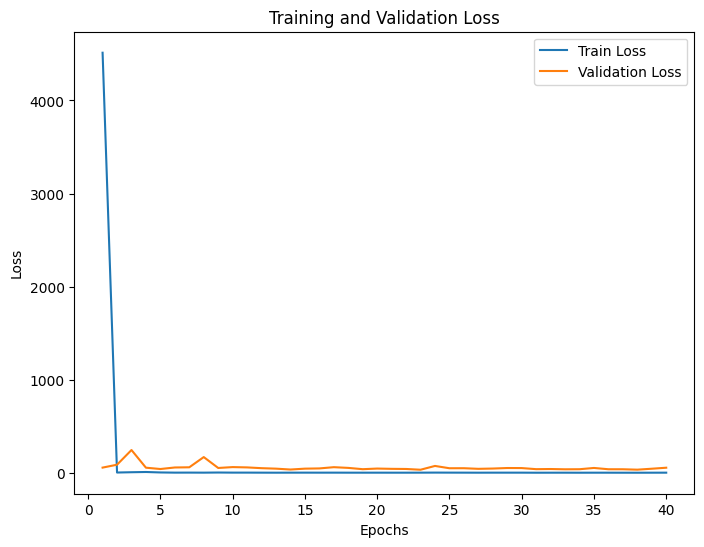

In [ ]:
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Generate a list of epoch numbers for the x-axis
epochs = list(range(1, len(train_loss_history) + 1))

# Create a new figure with specified size
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(epochs, train_loss_history, label='Train Loss')

# Plot validation loss
plt.plot(epochs, val_loss_history, label='Validation Loss')

# Label the axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to differentiate between train and validation loss
plt.legend()

# Set the title for the plot
plt.title('Training and Validation Loss')

# Display the plot
plt.show()


### **Step 15: Save the model**

Saving a trained model is essential to prevent retraining from scratch and to reuse the learned weights for further tasks such as inference or fine-tuning.

- model.state_dict() retrieves the model's parameters.
- torch.save(state_dict, assets_dir + "siamese_model_state_dict.pt") saves these parameters in a .pt file so that the model can be loaded later.

In [ ]:
# Save the model's state dictionary
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, assets_dir + "siamese_model_state_dict.pt")

### **Step 16: Load the model**

Loading a previously trained Siamese Network model for inference or further training.

- `torch.load(file_path)` loads the saved parameters.
- `loaded_model.load_state_dict()` applies these parameters to the new model instance.
- `loaded_model.to(device)` ensures the model is on the right hardware (CPU or GPU).
- After this, the model is ready to make predictions or be fine-tuned further.

In [ ]:
# Define the file path for the saved model
file_path = assets_dir + 'siamese_model_state_dict.pt'

# Initialize an instance of the Siamese Network
loaded_model = SiameseNetwork()

# Load the saved state dictionary into the initialized model
loaded_model.load_state_dict(torch.load(file_path))

# Move the model to the appropriate device (CPU/GPU)
loaded_model = loaded_model.to(device)


### **Step 17: Evaluating the Model**

The Euclidean distance is a commonly used metric to quantify the similarity between two feature vectors in image analysis. It calculates the straight-line distance between the points in the feature space. Smaller distances indicate higher similarity, while larger distances indicate dissimilarity. The Euclidean distance metric is intuitive and straightforward to compute, making it widely used in various applications such as image retrieval and clustering.

This step evaluates the Siamese Network by measuring the **Euclidean distance** between feature vectors of image pairs.

- **Euclidean distance** is used to quantify similarity:
  - **Smaller distance** → More similar images.
  - **Larger distance** → More dissimilar images.
- The model is set to **evaluation mode** to disable dropout and batch normalization updates.
- **Gradient calculations are disabled** to speed up inference and save memory.
- One image (`x0`) is compared against **10 other images**, and the dissimilarity scores are displayed.


In [ ]:
loaded_model = model

In [ ]:
import torchvision
from google.colab.patches import cv2_imshow

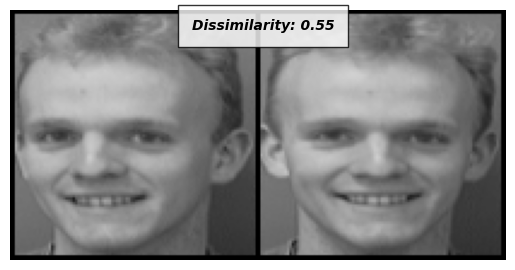

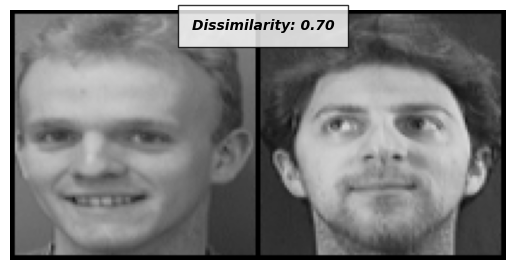

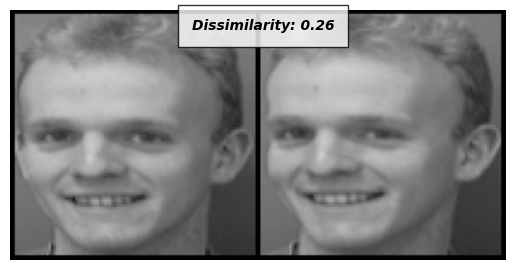

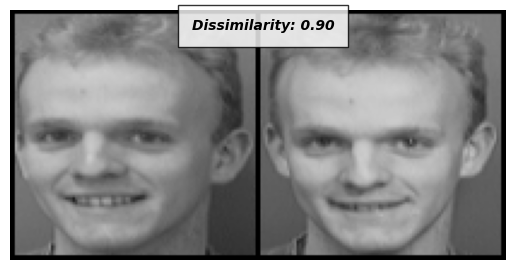

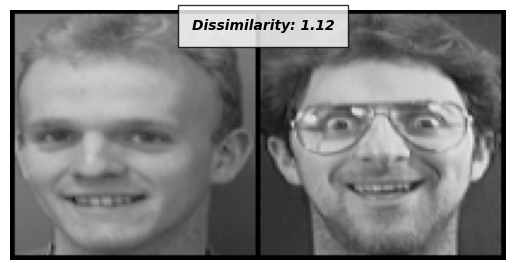

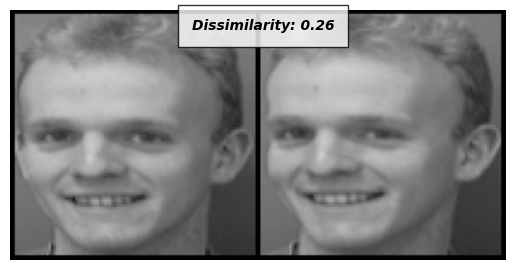

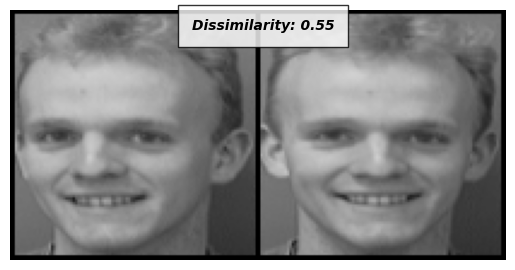

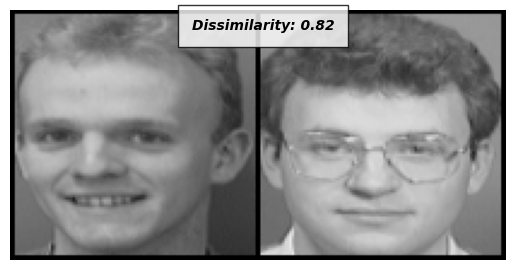

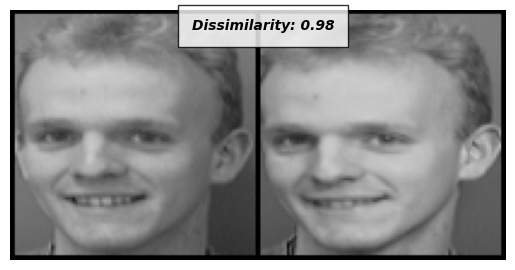

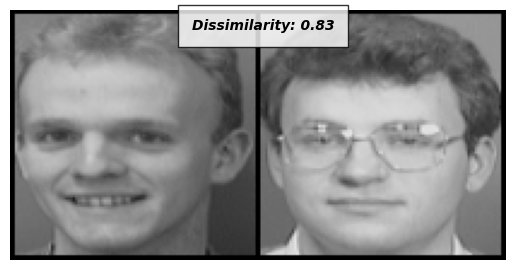

In [ ]:
# Set the model to evaluation mode (disables dropout, batch norm updates)
loaded_model.eval()

# Disable gradient calculations for faster inference
with torch.no_grad():
    # Get the first image from the test set
    dataiter = iter(test_loader)
    x0, _, _ = next(dataiter)  # x0 is the first image
    image1 = x0  # Store for visualization
    x0 = x0.to(device)  # Move to the correct device (CPU/GPU)

    # Compare this image with 10 others
    for i in range(10):
        _, x1, label2 = next(dataiter)  # Get another image x1
        image2 = x1  # Store for visualization
        x1 = x1.to(device)  # Move to device

        # Concatenate images side by side for visualization
        concatenated = torch.cat((image1, image2), 0)

        # Extract feature vectors using the Siamese Network
        output1, output2 = loaded_model(x0, x1)

        # Compute Euclidean distance between the feature vectors
        euclidean_distance = F.pairwise_distance(output1, output2)

        # Display the image pair with their dissimilarity score
        imshow(torchvision.utils.make_grid(concatenated),
               'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

As we can see some more training might be required but the results seem to be good with similar faces having lesser dissimilarity vs different faces having more dissimilarity.

## **Interpreting the Results**

The Siamese Network predicts **dissimilarity scores** using **Euclidean distance** between feature vectors. Lower scores indicate similarity, while higher scores suggest dissimilarity.

#### **Understanding Dissimilarity Scores:**
- **0.0 - 0.5** → Highly similar (likely same person)
- **0.5 - 1.0** → Moderately similar (small variations)
- **> 1.0** → Different (likely different people)

#### **Example Analysis:**
- **Score ~0.55 - 0.98** → Nearly identical images, same person.
- **Score ~0.82 - 0.90** → Some variations (pose, expression, glasses).
- **Score ~1.12** → Significant differences, likely different people.

#### **Factors Affecting Similarity:**
- **Same Person Variations** → Lighting, pose, expression, accessories.
- **Different People Similarities** → Twins, family resemblance.

#### **Key Takeaways:**
- **Thresholding:** Set a cutoff (e.g., `0.8`) to classify same/different.
- **Experiment:** Try different images, occlusions, and expressions.
- **Applications:** Used in **face recognition, verification, and matching**.





